In [9]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)
net

 Network attributes:
  vertices = 141 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 2874 
    missing edges= 0 
    non-missing edges= 2874 

 Vertex attribute names: 
    agriculture_forestry_fishing_of_gdp area colonizer continent country_iso3 foreign_direct_investment_inflows gdp_growth gdp_per_capita gdp_us_dollar gni_atlas happiness industry_of_gdp inflation_rate landlocked langoff_1 life_expectancy merchandise_of_gdp net_barter_of_trade population vertex.names 

 Edge attribute names not shown 

### Generating the adjacency matrix of the export network and the total Export/Import of all countries

In [10]:
countries_export_import = data.frame(
    country = c(nodes$country_iso3), 
    exports = matrix(0, nrow =n , ncol = 1),
    imports = matrix(0, nrow =n , ncol = 1)
)

In [11]:
for (i in 1:n) {
    countries_export_import[i, 2:3] = c(
        sum(edges$weight[edges$source == countries_export_import$country[i]]), 
        sum(edges$weight[edges$target == countries_export_import$country[i]])
    )
}

In [12]:
head(countries_export_import, 3)

,country,exports,imports
,<chr>,<dbl>,<dbl>
1,AFG,0.189,4417.172
2,AGO,4909.832,4013.016
3,ALB,425.820,13925.990


In [13]:
nodes$exports = countries_export_import$exports
nodes$imports = countries_export_import$imports

In [14]:
head(nodes, 3)

,country_iso3,merchandise_of_gdp,area,population,industry_of_gdp,continent,agriculture_forestry_fishing_of_gdp,life_expectancy,landlocked,colonizer,⋯,inflation_rate,langoff_1,gni_atlas,foreign_direct_investment_inflows,happiness,gdp_us_dollar,gdp_growth,gdp_per_capita,exports,imports
,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,38.70415,652225,30117411,22.74025,Asia,23.743664,61.553,TRUE,USA,⋯,11.804186,Persian,16077121256,52173421,0.721,17804292964,0.4263548,591.1628,0.189,4417.172
2,AGO,78.30597,1246700,24220660,56.02651,Africa,5.845681,56.330,FALSE,PRT,⋯,13.482468,Portuguese,82606027251,-3023770966,0.708,111789686464,3.4719763,4615.4682,4909.832,4013.016
3,ALB,56.86241,28748,2905195,24.48441,Europe,18.226765,76.914,FALSE,NONE,⋯,3.429123,Albanian,12803715190,1048706682,0.568,12890765324,2.5453218,4437.1429,425.820,13925.990


In [15]:
adj_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(edges$source == country_names[i] & edges$target == country_names[j]) > 0) {
            adj_matrix[i, j] = edges$weight[edges$source == country_names[i] & edges$target == country_names[j]]
        }
    }
}
diag(adj_matrix) = 0

### Loading the dataset of distances between countries

In [16]:
distance_data = read.csv('../datasets/wits/dist.csv')
head(distance_data, 3)

,source,target,dist
,<chr>,<chr>,<dbl>
1,AFG,AFG,303.7614
2,AFG,AGO,7607.8000
3,AFG,ALB,4342.1170


In [17]:
dist_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(distance_data$source == country_names[i] & distance_data$target == country_names[j]) > 0) {
            dist_matrix[i, j] = distance_data$dist[distance_data$source == country_names[i] & distance_data$target == country_names[j]]
        }
    }
}
dist_matrix = dist_matrix + t(dist_matrix)
diag(dist_matrix) = 0

In [18]:
# Execute QAP test given y_matrix as the dependent network and the x_matrix as the indepdent network. 
# This kind of permutation test finds the permutations of the indepdent network which are kept the dependencies within the independent network
execute_qaptest = function(y_matrix, x_matrix, reps=1000) {
    wits.qap = qaptest(dat = list(y_matrix, x_matrix), gcor, g1=1, g2=2, reps = 1000)
    print(wits.qap)
    print(wits.qap$testval)
    par(bg = 'white')
    plot(wits.qap, xlim=c(min(min(wits.qap$dist), wits.qap$testval), max(max(wits.qap$dist), wits.qap$testval)))
    abline(v=wits.qap$testval, col='red')
}


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0 
	p(f(perm) <= f(d)): 1 

[1] 0.03959313


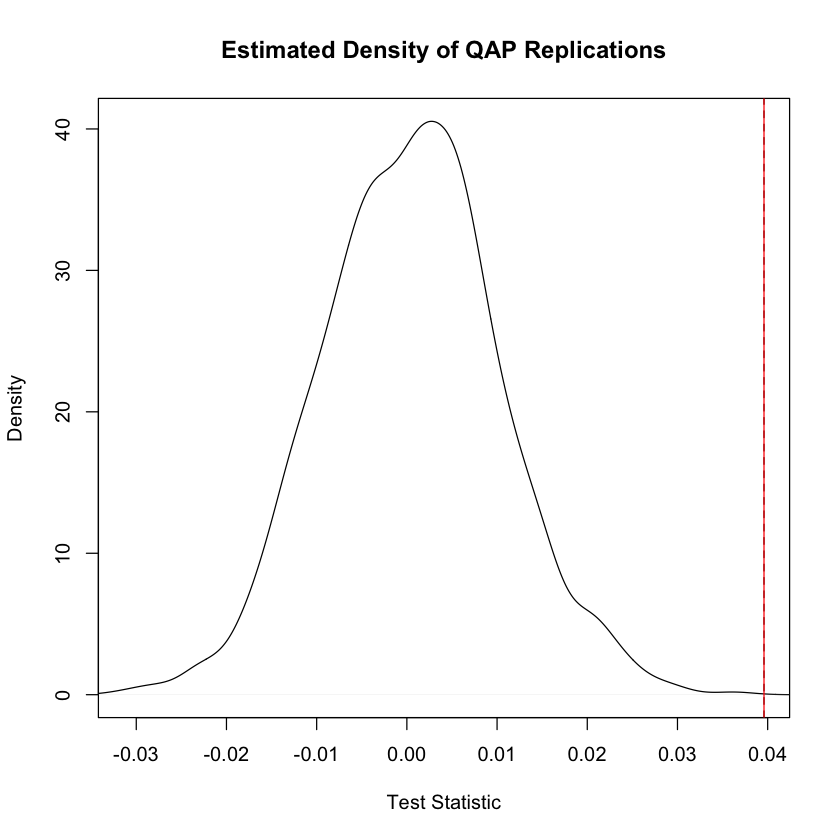

In [19]:
execute_qaptest(adj_matrix, dist_matrix)

### Checking the effect of colonization specifically in case of Great Britain

In [20]:
observed_statistic_exports_col = sum(nodes$exports[nodes$colonizer == 'GBR'])
observed_statistic_imports_col = sum(nodes$imports[nodes$colonizer == 'GBR'])

In [21]:
permutation_matrix_col = matrix(0, nrow = n, ncol = N)
for (i in 1:N) {
    permutation_matrix_col[, i] = sample(nodes$colonizer, size = n, replace = F)
}

In [22]:
permutated_statistic_exports_col = matrix(0, nrow=N, ncol=1)
permutated_statistic_imports_col = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    permutated_statistic_exports_col[i,] = sum(nodes$exports[permutation_matrix_col[,i] == 'GBR'])
    permutated_statistic_imports_col[i,] = sum(nodes$imports[permutation_matrix_col[,i] == 'GBR'])
}

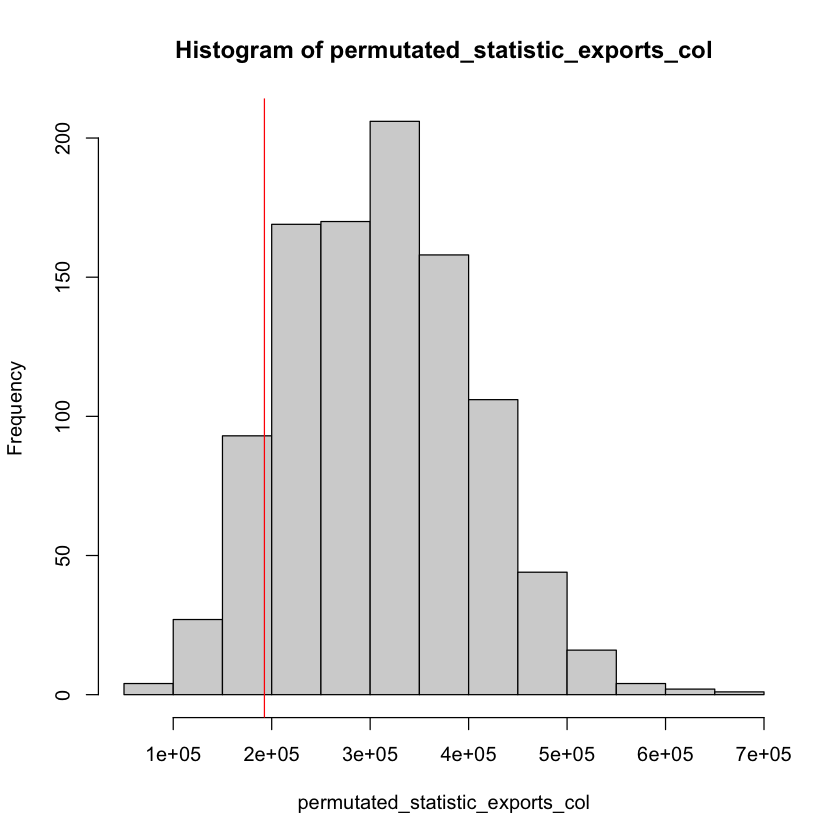

In [23]:
par(bg = 'white')
hist(permutated_statistic_exports_col)
abline(v=observed_statistic_exports_col, col='red')

In [24]:
mean(permutated_statistic_exports_col < observed_statistic_exports_col)

[1] 0.105

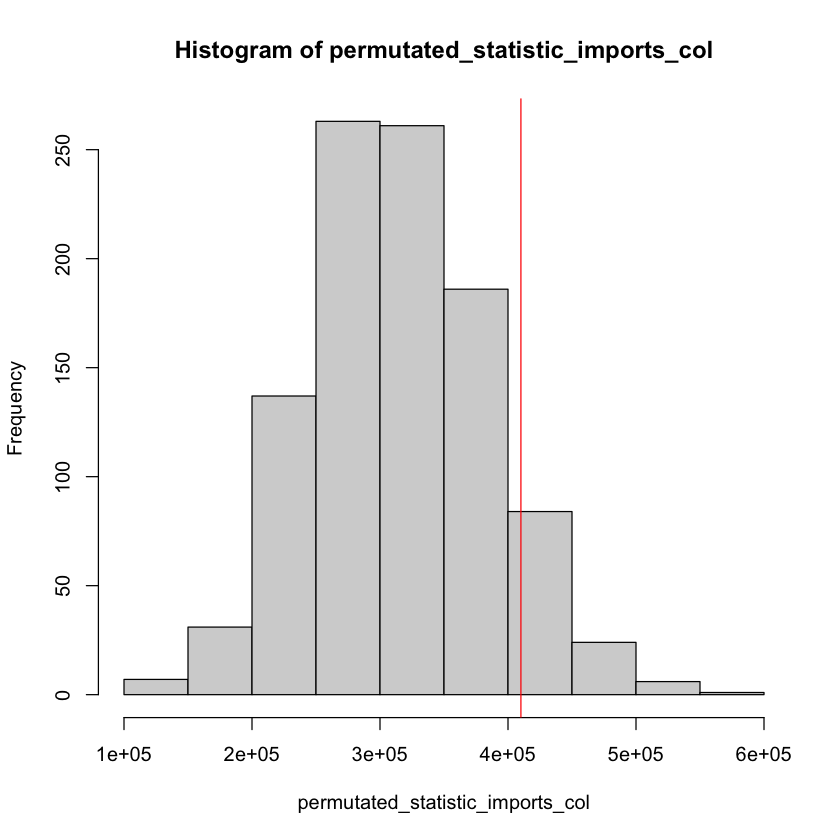

In [25]:
par(bg = 'white')
hist(permutated_statistic_imports_col)
abline(v=observed_statistic_imports_col, col='red')

In [26]:
mean(permutated_statistic_imports_col < observed_statistic_imports_col)

[1] 0.913

In [1]:
library(rmarkdown)

In [5]:
rmarkdown:::convert_ipynb('./permutation-tests-wits.ipynb', output = './permutation-tests-wits.Rmd')

In [6]:
rmarkdown:::convert_ipynb('./permutation-tests-wits-ergm.ipynb', output = './permutation-tests-wits-ergm.Rmd')

In [7]:
rmarkdown:::convert_ipynb('./permutation-tests-wits-residuals.ipynb', output = './permutation-tests-wits-residuals.Rmd')